In [8]:
import cv2
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import numpy as np
import math

# Fungsi helper untuk menampilkan dua gambar berdampingan
def display_side_by_side(image1, image2, title1="Image 1", title2="Image 2", main_title=""):
    """Menampilkan dua gambar dalam format RGB secara berdampingan."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Konversi dari BGR (OpenCV) ke RGB (Matplotlib)
    rgb_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    rgb_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(rgb_image1)
    ax1.set_title(title1)
    ax1.axis('off')
    
    ax2.imshow(rgb_image2)
    ax2.set_title(title2)
    ax2.axis('off')
    
    plt.suptitle(main_title, fontsize=16)
    plt.show()

In [9]:
def process_single_image(image_path, detector, target_size=(160, 160)):
    """
    Memproses satu gambar melalui pipeline dan mengembalikan hasilnya di setiap tahap.
    Mengembalikan dictionary berisi gambar-gambar hasil proses.
    """
    # Baca gambar
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Gambar tidak dapat ditemukan di path: {image_path}")
        return None
    
    # --- LANGKAH 1: DETEKSI WAJAH & LANDMARK ---
    results = detector.detect_faces(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results:
        print(f"Tidak ada wajah terdeteksi di {image_path}")
        return None

    face_data = results[0]
    bounding_box = face_data['box']
    keypoints = face_data['keypoints']

    # Buat salinan gambar untuk visualisasi
    img_with_box_and_landmarks = image.copy()
    
    # Perbesar ketebalan garis dan ukuran font
    thickness = max(2, int(image.shape[1] / 300)) # Ketebalan dinamis
    font_scale = max(0.7, image.shape[1] / 1000)

    # Gambar bounding box yang lebih tebal
    x, y, w, h = bounding_box
    cv2.rectangle(img_with_box_and_landmarks, (x, y), (x + w, y + h), (0, 255, 0), thickness * 2)

    # Gambar titik landmark (mata, hidung, mulut)
    # Ini adalah visualisasi dari 'facial landmark detection'
    cv2.circle(img_with_box_and_landmarks, keypoints['left_eye'], thickness, (255, 0, 0), -1)
    cv2.circle(img_with_box_and_landmarks, keypoints['right_eye'], thickness, (255, 0, 0), -1)
    cv2.circle(img_with_box_and_landmarks, keypoints['nose'], thickness, (0, 0, 255), -1)
    cv2.circle(img_with_box_and_landmarks, keypoints['mouth_left'], thickness, (0, 255, 255), -1)
    cv2.circle(img_with_box_and_landmarks, keypoints['mouth_right'], thickness, (0, 255, 255), -1)
    
    # --- LANGKAH 2: ALIGNMENT WAJAH ---
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(math.atan2(dY, dX))

    (h_img, w_img) = image.shape[:2]
    center = (w_img // 2, h_img // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    aligned_image = cv2.warpAffine(image, M, (w_img, h_img), flags=cv2.INTER_CUBIC)
    
    # Deteksi ulang untuk mendapatkan bounding box yang pas setelah alignment
    aligned_results = detector.detect_faces(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
    if not aligned_results:
        # Jika gagal, crop manual berdasarkan box awal (kurang akurat)
        x_a, y_a, w_a, h_a = x,y,w,h
    else:
        x_a, y_a, w_a, h_a = aligned_results[0]['box']
    
    margin_x = int(w_a * 0.2)
    margin_y = int(h_a * 0.2)
    x1, y1 = max(0, x_a - margin_x), max(0, y_a - margin_y)
    x2, y2 = min(aligned_image.shape[1], x_a + w_a + margin_x), min(aligned_image.shape[0], y_a + h_a + margin_y)
    
    aligned_cropped_face = aligned_image[y1:y2, x1:x2]

    # --- LANGKAH 3: RESIZING & PADDING ---
    (h_face, w_face) = aligned_cropped_face.shape[:2]
    scale = min(target_size[0] / w_face, target_size[1] / h_face)
    new_w, new_h = int(w_face * scale), int(h_face * scale)
    
    resized_face = cv2.resize(aligned_cropped_face, (new_w, new_h))
    
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    final_image = cv2.copyMakeBorder(resized_face, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Kumpulkan semua hasil dalam dictionary
    processed_images = {
        "detection": img_with_box_and_landmarks,
        "alignment": aligned_cropped_face,
        "final": final_image
    }
    
    return processed_images

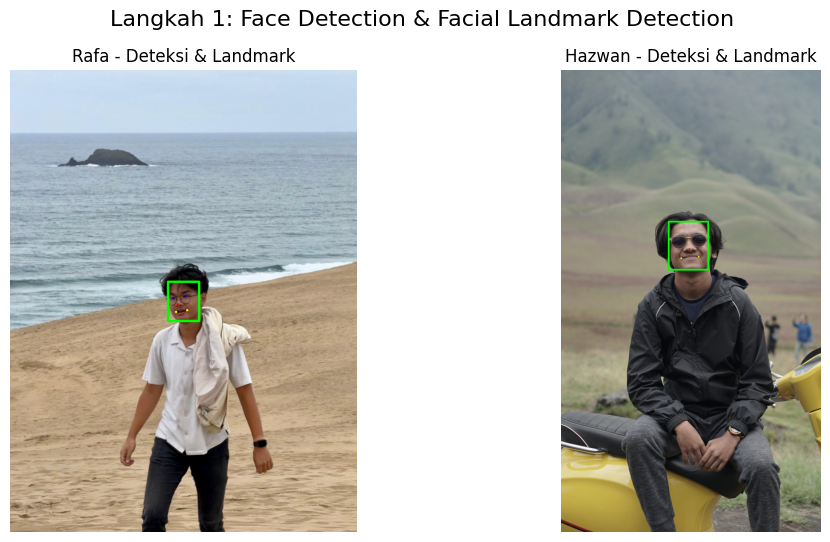

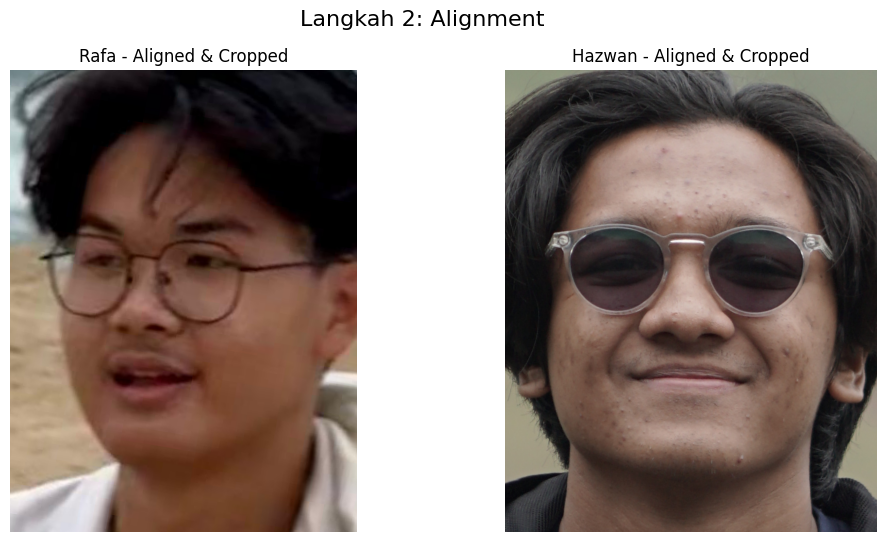

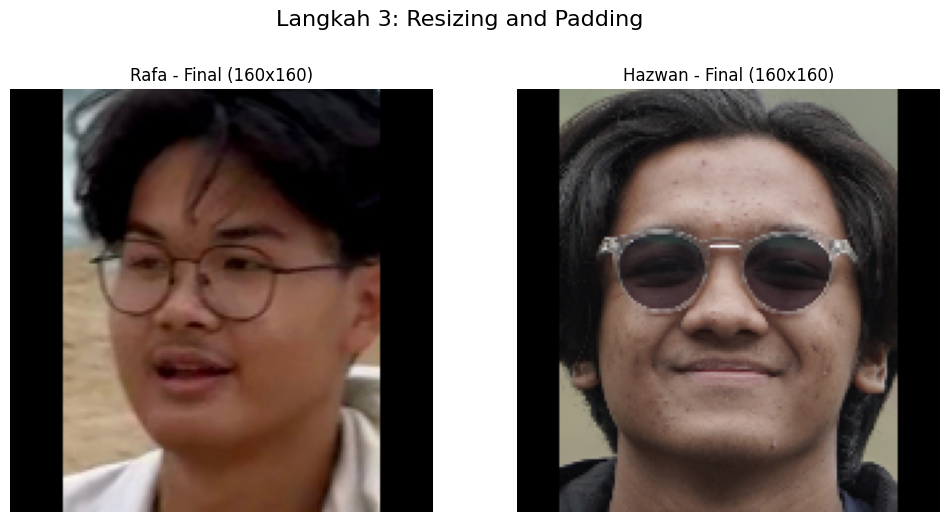

In [11]:
# Inisialisasi detektor MTCNN sekali saja untuk efisiensi
detector = MTCNN()

# Tentukan path gambar Anda
path_rafa = "./face-sim/src/img/rafa.png"
path_hazwan = "./face-sim/src/img/hazwan.jpg"

# Proses kedua gambar
results_rafa = process_single_image(path_rafa, detector)
results_hazwan = process_single_image(path_hazwan, detector)

if results_rafa and results_hazwan:
    # --- Visualisasi Langkah 1: Deteksi Wajah & Landmark ---
    # Titik-titik biru (mata), merah (hidung), dan cyan (mulut) adalah hasil dari 'facial landmark detection'
    display_side_by_side(
        results_rafa["detection"], 
        results_hazwan["detection"],
        title1="Rafa - Deteksi & Landmark",
        title2="Hazwan - Deteksi & Landmark",
        main_title="Langkah 1: Face Detection & Facial Landmark Detection"
    )
    
    # --- Visualisasi Langkah 2: Alignment & Cropping ---
    # Gambar wajah sudah diputar agar mata sejajar dan dipotong
    display_side_by_side(
        results_rafa["alignment"], 
        results_hazwan["alignment"],
        title1="Rafa - Aligned & Cropped",
        title2="Hazwan - Aligned & Cropped",
        main_title="Langkah 2: Alignment"
    )

    # --- Visualisasi Langkah 3: Resizing & Padding ---
    # Gambar final siap untuk dimasukkan ke model
    display_side_by_side(
        results_rafa["final"], 
        results_hazwan["final"],
        title1="Rafa - Final (160x160)",
        title2="Hazwan - Final (160x160)",
        main_title="Langkah 3: Resizing and Padding"
    )